In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from zipfile import ZipFile
import cv2

In [8]:
with ZipFile(r'Machine-Learning\Image_classification_data.zip', 'r') as zipobj:
    zipobj.extractall('colon_data')


In [9]:
image_dir = 'colon_data'
print(os.listdir(image_dir))

['data_labels_extraData.csv', 'data_labels_mainData.csv', 'patch_images', '__MACOSX']


In [10]:
#Loading CSV
df2 = pd.read_csv('colon_data/data_labels_mainData.csv')
df1 = pd.read_csv('colon_data/data_labels_extraData.csv')

In [11]:
df2.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


In [12]:
df1.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


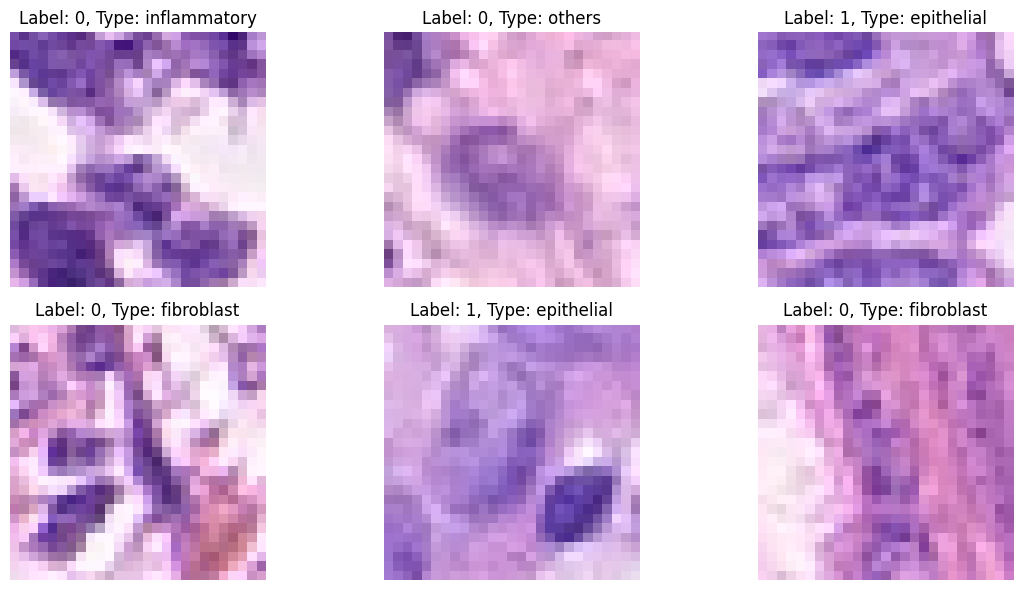

In [13]:
image_dir = 'colon_data/patch_images'

def display_sample_images(df, num_samples=6):
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 6))

    for i, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(image_dir, row['ImageName'])
        img = Image.open(img_path)
 
        # Dynamically build the title
        title = f"Label: {row['isCancerous']}"
        if 'cellTypeName' in row:
            title += f", Type: {row['cellTypeName']}"

        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Display samples from main_df(df2)
display_sample_images(df2)

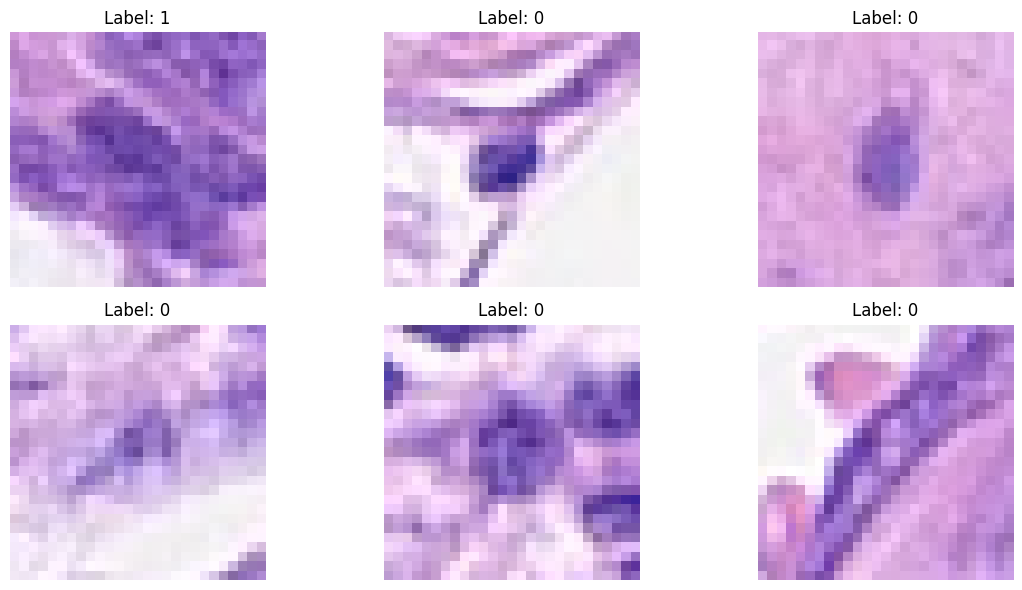

In [71]:
display_sample_images(df1)

# Exploratory Data Analysis

# Are All Cell Types Equally Cancerous?

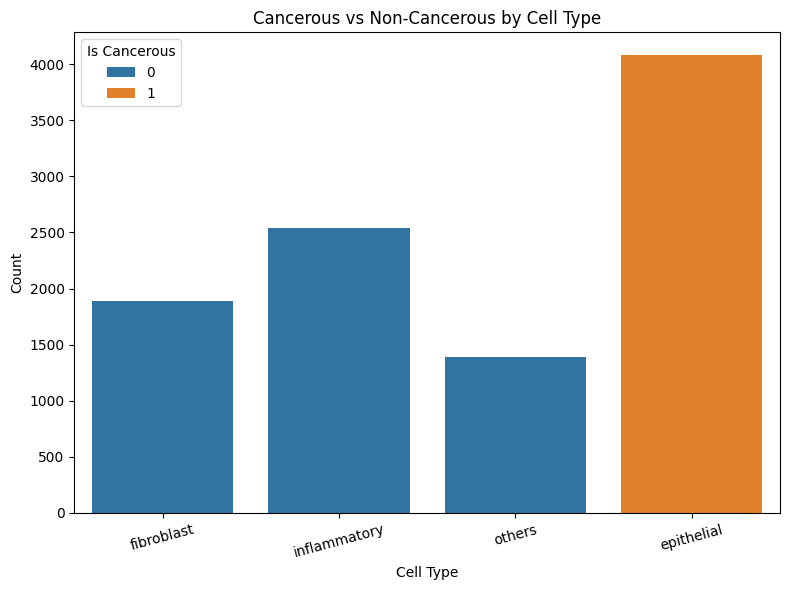

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(x='cellTypeName', hue='isCancerous', data=df2)
plt.title('Cancerous vs Non-Cancerous by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.legend(title='Is Cancerous')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Relationship Between Cell Type and Cancer Status

The grouped bar chart illustrates the distribution of cancerous (1) and non-cancerous (0) labels across different cell types.

- Nearly all **epithelial** cells are labeled as cancerous.
- In contrast, **fibroblast**, **inflammatory**, and **others** are predominantly non-cancerous.



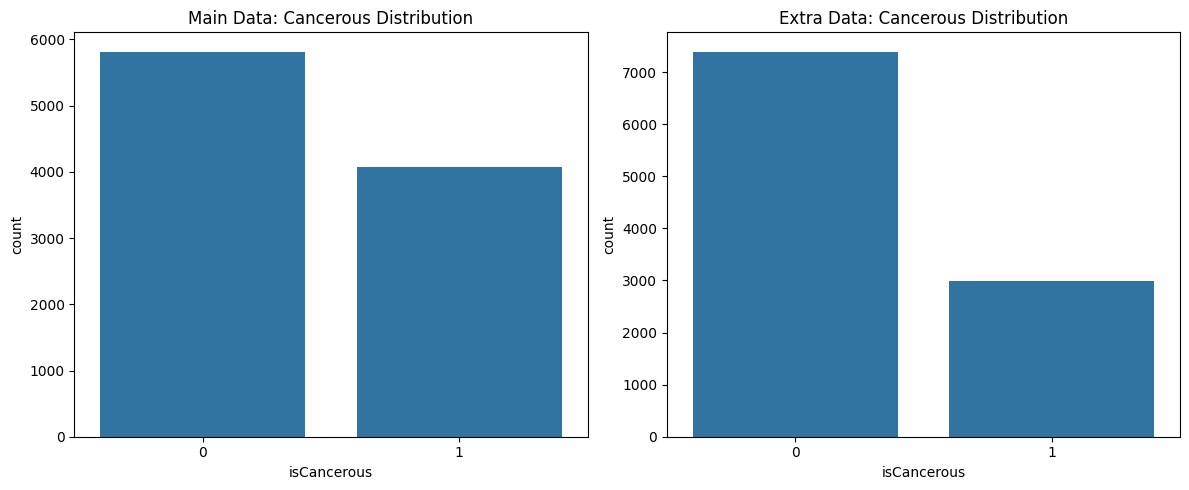

In [73]:
# Check cancerous label distribution in main and extra data
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(x='isCancerous', data=df2, ax=axs[0])
axs[0].set_title('Main Data: Cancerous Distribution')

sns.countplot(x='isCancerous', data=df1, ax=axs[1])
axs[1].set_title('Extra Data: Cancerous Distribution')

plt.tight_layout()
plt.show()


### Distribution of cancerous vs. non-cancerous labels in both datasets
The bar charts illustrate the distribution of cancerous (1) and non-cancerous (0) labels in both the Main Data and Extra Data.
- In the Main Data, the count of non-cancerous samples (0) is noticeably higher than the count of cancerous samples (1), indicating a class imbalance.
- Similar pattern is observed in the Extra Data, where non-cancerous samples are also more prevalent than cancerous ones.

In [78]:
print("Missing values in df2:")
print(df2.isnull().sum())

print("\nMissing values in df1:")
print(df1.isnull().sum())

Missing values in df2:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

Missing values in df1:
InstanceID     0
patientID      0
ImageName      0
isCancerous    0
dtype: int64


### Checking missing values
This displays the count of missing values per column in both the Main Data (df2) and Extra Data (df1).
- There are no missings values found in any dataset

100%|██████████| 9896/9896 [01:20<00:00, 122.32it/s]


        Width  Height  Channels
count  9896.0  9896.0    9896.0
mean     27.0    27.0       3.0
std       0.0     0.0       0.0
min      27.0    27.0       3.0
25%      27.0    27.0       3.0
50%      27.0    27.0       3.0
75%      27.0    27.0       3.0
max      27.0    27.0       3.0


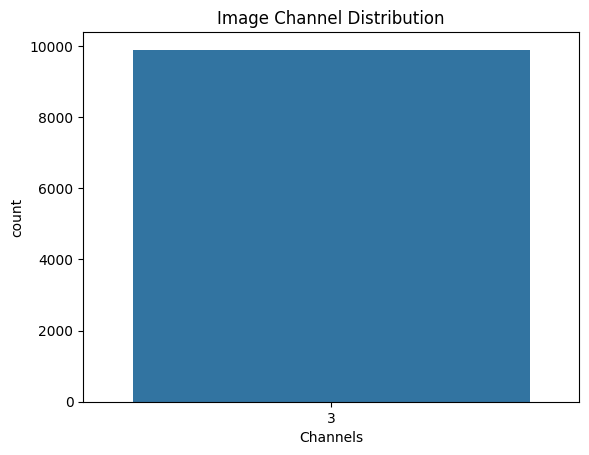

In [14]:
from tqdm import tqdm

def get_image_shapes(df):
    shapes = []
    for img_name in tqdm(df['ImageName']):
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        shapes.append(img.size + (len(img.getbands()),))  # (width, height, channels)
    return shapes

shapes_main = get_image_shapes(df2)
shapes_df = pd.DataFrame(shapes_main, columns=['Width', 'Height', 'Channels'])
print(shapes_df.describe())

sns.countplot(x='Channels', data=shapes_df)
plt.title('Image Channel Distribution')
plt.show()

### Image Dimension and Channel Analysis of Dataset
This analysis examined the dimensions and channel configuration of all 9,896 images in the dataset using the tqdm progress bar to track processing.
- All images have the same dimensions of 27x27 pixels.
- Each image has 3 channels, suggesting that they are RGB colour images.
- The seaborn countplot of the Channels column shows a single bar at 3, reinforcing that all images are in color and none are grayscale (1 channel) or RGBA (4 channels).

Since we are developing two distinct machine learning models—one for predicting cell type and another for identifying whether a cell is cancerous—we will first extract only the relevant columns which would be used for predictions (ImageName, isCancerous) from df1 and then append (concatenate) them to df2 so that we have a unified dataset to work with.

So we will make 2 dataframes (dfcancer) and another dfcell)

In [39]:
dfcancer = pd.concat([df2[['ImageName', 'isCancerous']],df1[['ImageName', 'isCancerous']]],axis = 0)
dfcell = df2[['ImageName','cellType']]

# Checking For Class Imbalance

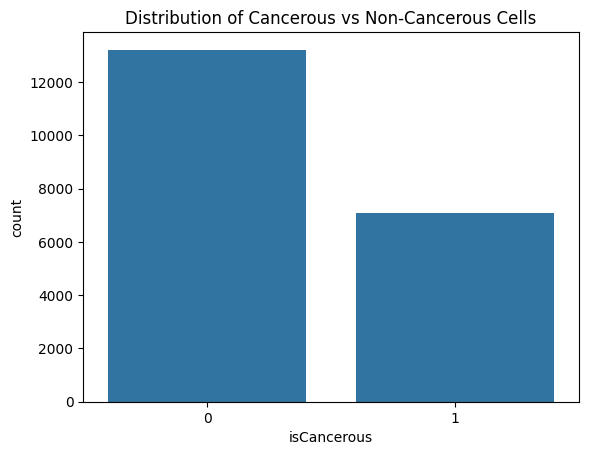

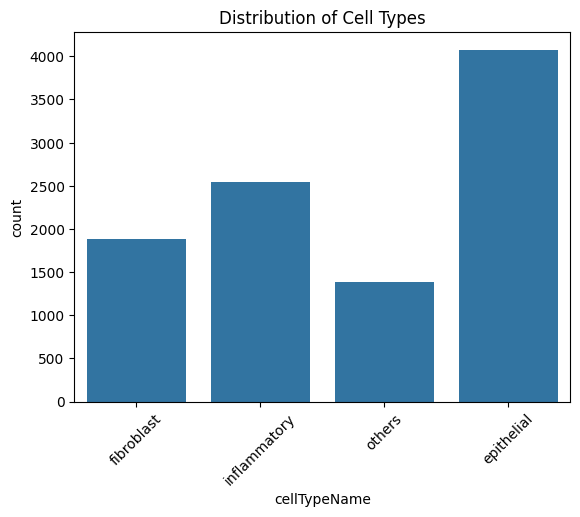

In [40]:
sns.countplot(x='isCancerous', data=dfcancer)
plt.title('Distribution of Cancerous vs Non-Cancerous Cells')
plt.show()

# cellType distribution
sns.countplot(x='cellTypeName', data=df2)
plt.title('Distribution of Cell Types')
plt.xticks(rotation=45)
plt.show()

# **Class Imbalance Identification**
1. ***isCancerous Distribution***
The bar chart for the isCancerous label shows a noticeable class imbalance.

The majority of samples are non-cancerous (label 0), accounting for 13211 samples.

In contrast, cancerous (label 1) samples total just around 7069.

**Implication**: If left unaddressed, this imbalance can cause a binary classifier to be biased toward predicting the majority class (non-cancerous), potentially leading to high accuracy but poor recall for the cancerous class — which is medically critical.

2. ***Cell Type Distribution***
The distribution of cellTypeName reveals a moderate class imbalance:

The epithelial category is the most represented, with more than 4,000 instances.

In contrast, classes such as others and fibroblast have less than 2,000 samples each.

**Implication**: In a multi-class classification task, this imbalance may lead the model to favor the dominant class (epithelial), while performing poorly on underrepresented categories. This could negatively impact metrics like the macro F1-score and reduce the model's ability to generalize across all classes.

# **✅ Techniques we will use to Handle Class Imbalance**

1.**Data Augmentation (for minority classes):** So what it does is basically it artificially increases the size of underrepresented classes by creating modified versions of their images.

2.**Class Weights**: Assign higher importance to minority classes during training.


We will deal with the class imbalance later in the codes as before that we wanna deal with the preprocessing first

# **Data Preprocessing**

SPLITTING THE DATASET INTO TRAIN AND TEST dataset(80% training data  ,20% test data)

In [41]:
traindfcancer,testdfcancer = train_test_split(dfcancer, test_size=0.2, random_state=42)
traindfcell,testdfcell = train_test_split(dfcell, test_size=0.2, random_state=42)

In [42]:
# Function to load and preprocess images
def load_and_preprocess_images(df):
    images = []
    for img_name in df['ImageName']:
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = np.array(img) / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load images (X Features)
Xcancertrain = load_and_preprocess_images(traindfcancer)
Xcancertest = load_and_preprocess_images(testdfcancer)
Xcelltrain = load_and_preprocess_images(traindfcell)
Xcelltest = load_and_preprocess_images(testdfcell)

In [43]:
#Target Column
ycancertrain = traindfcancer['isCancerous'].values
ycancertest = testdfcancer['isCancerous'].values
ycelltrain = traindfcell['cellType'].values
ycelltest = testdfcell['cellType'].values

# **Handling Class Imbalance for isCancerous Column**

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator with augmentation
augment_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Validation data generator (no augmentation)
val_gen = ImageDataGenerator()

# Flow from numpy arrays
train_gen = augment_gen.flow(Xcancertrain, ycancertrain, batch_size=32, shuffle=True)
val_gen = val_gen.flow(Xcancertest, ycancertest, batch_size=32, shuffle=False)

# Model for Binary Classification(isCancerous)

In [45]:
from tensorflow.keras import layers, models, regularizers

def create_cancer_cnn(input_shape=(27, 27, 3)):
    l2 = regularizers.l2(0.001)  # L2 regularization strength

    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.6))  # Still keeping dropout for extra regularization

    model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

    return model

model = create_cancer_cnn()

In [46]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

model.compile(
    optimizer=Adam(learning_rate=1e-4),  # smaller learning rate for stability
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [47]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight('balanced', classes=np.unique(ycancertrain), y=ycancertrain)
class_weight_dict = dict(enumerate(class_weights))

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',      # You can also monitor 'val_accuracy'
    patience=3,              # Stop if no improvement for 3 epochs
    restore_best_weights=True  # Roll back to best model
)

In [49]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,
    class_weight=class_weight_dict,
    callbacks=[early_stop]# optional but recommended
)

Epoch 1/15
507/507 [==============================] - 11s 20ms/step - loss: 0.7433 - accuracy: 0.7199 - val_loss: 0.5606 - val_accuracy: 0.7988
Epoch 2/15
507/507 [==============================] - 11s 21ms/step - loss: 0.5544 - accuracy: 0.7874 - val_loss: 0.4526 - val_accuracy: 0.8407
Epoch 3/15
507/507 [==============================] - 10s 21ms/step - loss: 0.5219 - accuracy: 0.7982 - val_loss: 0.4585 - val_accuracy: 0.8319
Epoch 4/15
507/507 [==============================] - 10s 19ms/step - loss: 0.5032 - accuracy: 0.8097 - val_loss: 0.4637 - val_accuracy: 0.8269
Epoch 5/15
507/507 [==============================] - 10s 20ms/step - loss: 0.4884 - accuracy: 0.8121 - val_loss: 0.4218 - val_accuracy: 0.8503
Epoch 6/15
507/507 [==============================] - 9s 18ms/step - loss: 0.4841 - accuracy: 0.8151 - val_loss: 0.4052 - val_accuracy: 0.8540
Epoch 7/15
507/507 [==============================] - 9s 18ms/step - loss: 0.4723 - accuracy: 0.8207 - val_loss: 0.4076 - val_accuracy: 0

# **Evaluation**

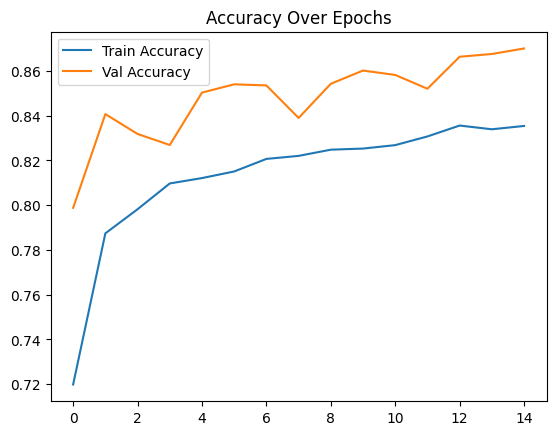

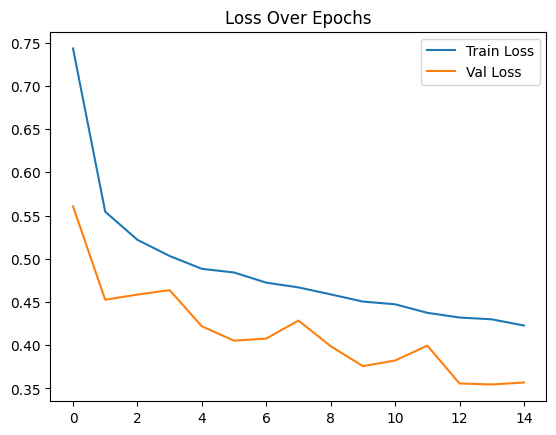

In [50]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


127/127 [==============================] - 1s 4ms/step


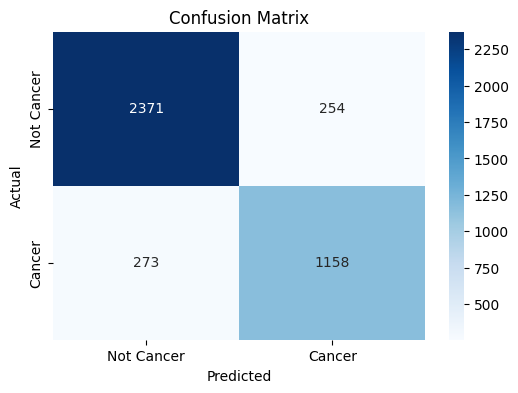

Classification Report:

              precision    recall  f1-score   support

  Not Cancer       0.90      0.90      0.90      2625
      Cancer       0.82      0.81      0.81      1431

    accuracy                           0.87      4056
   macro avg       0.86      0.86      0.86      4056
weighted avg       0.87      0.87      0.87      4056



In [51]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on test data
y_pred_probs = model.predict(Xcancertest)
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()  # Convert probabilities to 0 or 1

# Step 2: Confusion Matrix
cm = confusion_matrix(ycancertest, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Cancer', 'Cancer'], yticklabels=['Not Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Step 3: Classification Report
print("Classification Report:\n")
print(classification_report(ycancertest, y_pred, target_names=['Not Cancer', 'Cancer']))


## Model For multi-class cell type classification

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

val_gen = ImageDataGenerator()

from tensorflow.keras.utils import to_categorical

# One-hot encode labels
ycelltrain_cat = to_categorical(ycelltrain, num_classes=4)
ycelltest_cat = to_categorical(ycelltest, num_classes=4)

# Now generate flows
train_flow = train_gen.flow(Xcelltrain, ycelltrain_cat, batch_size=32, shuffle=True)
val_flow = val_gen.flow(Xcelltest, ycelltest_cat, batch_size=32, shuffle=False)

In [53]:
from tensorflow.keras import layers, models, regularizers

def create_celltype_cnn(input_shape=(27, 27, 3), num_classes=4):
    l2 = regularizers.l2(0.001)

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2, input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Multi-class

    return model

model2 = create_celltype_cnn()

In [54]:
from tensorflow.keras.optimizers import Adam

model2.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history2 = model2.fit(
    train_flow,
    validation_data=val_flow,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
248/248 [==============================] - 6s 20ms/step - loss: 1.4633 - accuracy: 0.4592 - val_loss: 1.2672 - val_accuracy: 0.5909
Epoch 2/30
248/248 [==============================] - 5s 19ms/step - loss: 1.1830 - accuracy: 0.5889 - val_loss: 1.0635 - val_accuracy: 0.6273
Epoch 3/30
248/248 [==============================] - 4s 18ms/step - loss: 1.0531 - accuracy: 0.6460 - val_loss: 0.9774 - val_accuracy: 0.6556
Epoch 4/30
248/248 [==============================] - 5s 19ms/step - loss: 0.9880 - accuracy: 0.6578 - val_loss: 0.9437 - val_accuracy: 0.6707
Epoch 5/30
248/248 [==============================] - 4s 18ms/step - loss: 0.9657 - accuracy: 0.6646 - val_loss: 0.9789 - val_accuracy: 0.6490
Epoch 6/30
248/248 [==============================] - 5s 21ms/step - loss: 0.9445 - accuracy: 0.6728 - val_loss: 0.9029 - val_accuracy: 0.6833
Epoch 7/30
248/248 [==============================] - 5s 18ms/step - loss: 0.9116 - accuracy: 0.6861 - val_loss: 0.8813 - val_accuracy: 0.7005

In [56]:
# Get model predictions
y_pred_probs = model2.predict(Xcelltest)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
y_true_classes = np.argmax(ycelltest_cat, axis=1)  # True labels

62/62 [==============================] - 0s 3ms/step


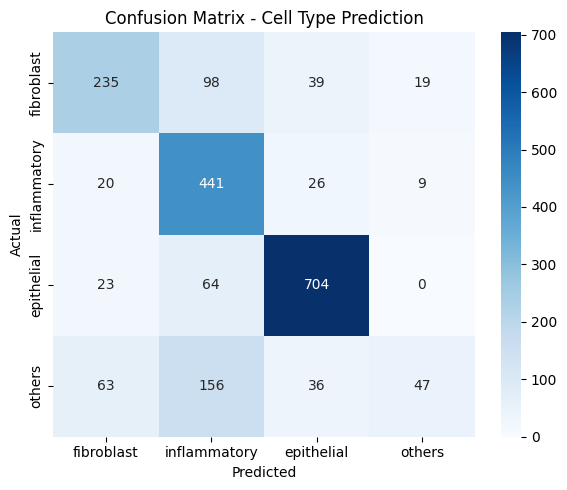

In [57]:
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'],
            yticklabels=['fibroblast', 'inflammatory', 'epithelial', 'others'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Cell Type Prediction')
plt.tight_layout()
plt.show()

In [58]:
# Print classification report
print("Classification Report:\n")
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=['fibroblast', 'inflammatory', 'epithelial', 'others']
))


Classification Report:

              precision    recall  f1-score   support

  fibroblast       0.69      0.60      0.64       391
inflammatory       0.58      0.89      0.70       496
  epithelial       0.87      0.89      0.88       791
      others       0.63      0.16      0.25       302

    accuracy                           0.72      1980
   macro avg       0.69      0.63      0.62      1980
weighted avg       0.73      0.72      0.69      1980



⚠️ Key Observations
Class "others" is frequently misclassified, especially as inflammatory and fibroblast.

Confusion matrix shows heavy misclassification of "others" as inflammatory — suggests they share similar features in images.

Macro F1-score is 0.60, pulled down by the poor performance on the "others" class.